In [491]:
# The SpikeGLX metadata file must be present in the same directory as the binary file.
import tdt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from DemoReadSGLXData.readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital
from sklearn.linear_model import LinearRegression
from scipy.io import savemat

In [77]:
def plot_pulses(onset_times, offset_times, nPulsesToPlot=100):
    edge_times = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    edge_times[0::2] = onset_times
    edge_times[1::2] = offset_times
    
    sync_levels = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    sync_levels[0::2] = 1
    sync_levels[1::2] = 0

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.step(edge_times[:nPulsesToPlot], sync_levels[:nPulsesToPlot], where='post')

# Load SGLX

In [78]:
def select_sglx_file():
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askopenfilename(title="Select SpikeGLX binary file"))

    root.destroy()
    
    return fullPath

In [79]:
def sglx_load_sync(sglx_file):
    meta = readMeta(sglx_file)
    rawData = makeMemMapRaw(sglx_file, meta)

    # Read the entire file
    firstSamp = 0
    lastSamp = rawData.shape[1]-1

    # Which digital word to read. 
    # For imec, there is only 1 digital word, dw = 0.
    # For NI, digital lines 0-15 are in word 0, lines 16-31 are in word 1, etc.
    dw = 0    
    # Which lines within the digital word, zero-based
    # Note that the SYNC line for PXI 3B is stored in line 6.
    dLineList = [6]
        
    return ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta)

In [80]:
def sglx_onset_samples(sync):
    # Onsets are the first samples where a value is high after being low. If sample 0 is high, the first onset is sample 0. Consistent with TDT convention.
    onset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == 1)[0]
    assert(onset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    return onset_samples

In [119]:
def sglx_offset_samples(sync):
    # Offsets are the first samples wehre a value is low after being high. If the last sample is high, the last offset is Inf. Consistent with TDT convention.
    offset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == -1)[0]
    assert(offset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    if np.squeeze(sync)[-1] == 1:
        offset_samples = np.append(offset_samples, np.Inf)
    return offset_samples

In [120]:
sglx_file = select_sglx_file()
sglx_sync = sglx_load_sync(sglx_file)
sglx_fs = SampRate(readMeta(sglx_file))
sglx_onset_times = sglx_onset_samples(sglx_sync) / sglx_fs
sglx_offset_times = sglx_offset_samples(sglx_sync) / sglx_fs

nChan: 385, nFileSamp: 84295130


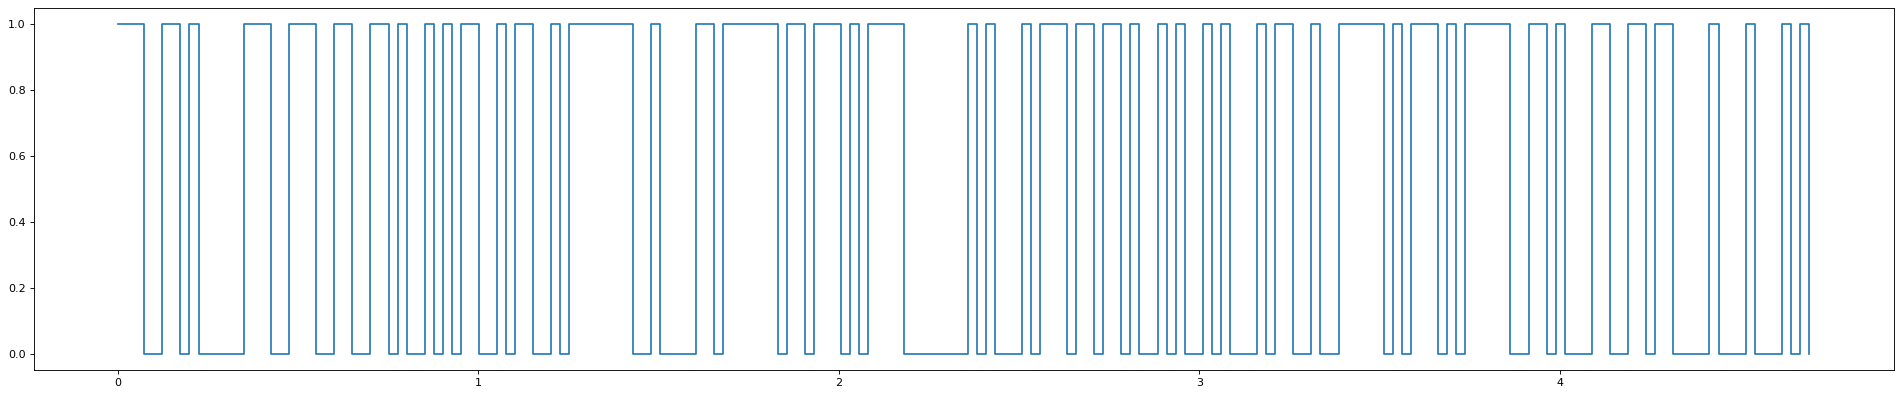

In [121]:
plot_pulses(sglx_onset_times, sglx_offset_times)

# Load TDT

In [84]:
def select_tdt_block():
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askdirectory(title="Select TDT block"))

    root.destroy()
    
    return fullPath

In [117]:
tdt_file = select_tdt_block()
tdt_data = tdt.read_block(tdt_file, evtype=['epocs'])
tdt_onset_times = tdt_data.epocs.PC0_.onset # TDT calls the onset of a signal that starts high "0", but the off set of a signal that ends high "inf"
tdt_offset_times = tdt_data.epocs.PC0_.offset

read from t=0s to t=2808.57s


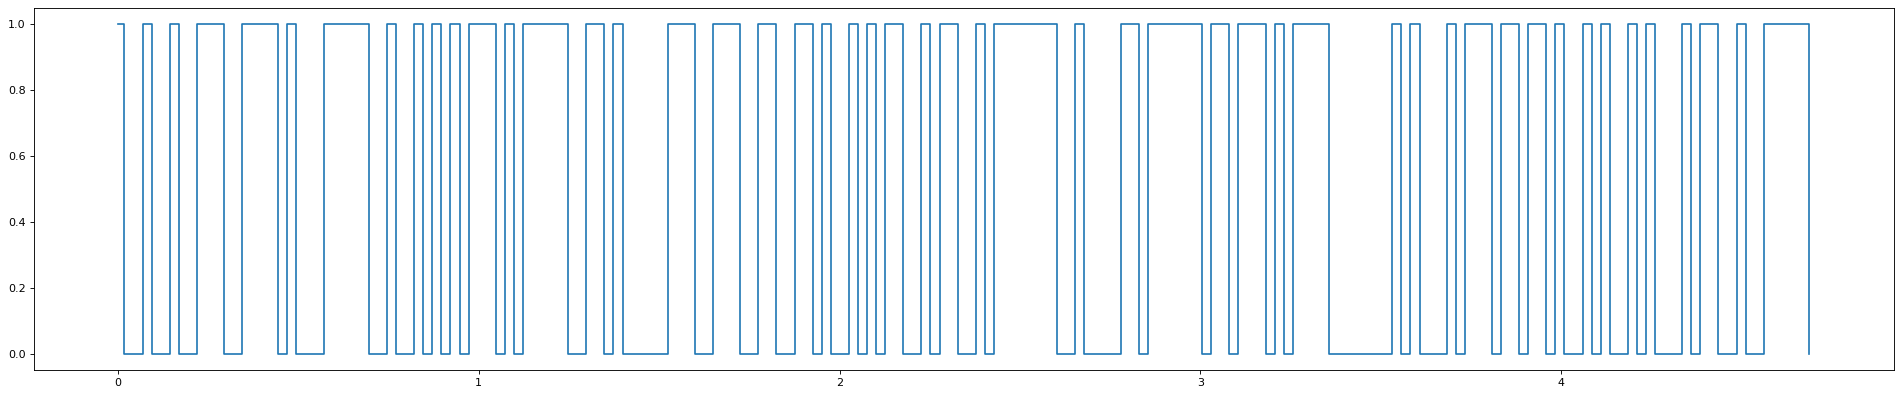

In [122]:
plot_pulses(tdt_onset_times, tdt_offset_times)

# Iteratively shift pulse trains relative to each other and regress

In [130]:
sglx_onset_times

array([0.00000000e+00, 1.22765972e-01, 1.98065547e-01, ...,
       2.80953285e+03, 2.80968348e+03, 2.80973371e+03])

In [127]:
tdt_onset_times

array([0.00000000e+00, 6.77478400e-02, 1.43073280e-01, ...,
       2.80834339e+03, 2.80839361e+03, 2.80846893e+03])

In [134]:
def strip_high_start(onset_times):
    return onset_times[np.where(onset_times > 0)]

In [142]:
def equalize_lengths(x, y):
    n = np.min([np.size(x), np.size(y)])
    return (x[:n], y[:n])

In [143]:
def preprocess_onset_times(x, y):
    x = strip_high_start(x)
    y = strip_high_start(y)
    return equalize_lengths(x, y)

In [150]:
(sglx_t, tdt_t) = preprocess_onset_times(sglx_onset_times, tdt_onset_times)

In [208]:
def shift(sglx_t, tdt_t, n_pulses, direction):
    
    if direction == 'forward':
        y = sglx_t[n_pulses:]
        x = tdt_t[:np.size(y)].reshape((-1, 1))
    elif direction == 'backward':
        x = tdt_t[n_pulses:].reshape((-1, 1))
        y = sglx_t[:np.size(x)]
    else:
        raise("Shift direction must be specified")
    
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)

    return model, r_sq

In [209]:
def eval_shift(sglx_t, tdt_t, n_pulses, direction):
    model, r_sq = shift(sglx_t, tdt_t, n_pulses, direction)
    return r_sq

In [216]:
def _find_mapping(sglx_t, tdt_t, direction, max_shift=None, plot=True):
    if max_shift is None:
        max_shift = np.size(sglx_t) - 1000
    
    shifts = np.arange(max_shift)
    
    fits = np.array([eval_shift(sglx_t, tdt_t, n, direction) for n in shifts])
    
    if plot:
        plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(shifts, fits)
    
    best_shift = shifts[np.argmax(fits)]  
    model, r_sq = shift(sglx_t, tdt_t, best_shift, direction)
    
    print(direction)
    print('number of pulses shifted:', best_shift)
    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('drift rate in msec/hr:', (model.coef_[0] - 1)*60*60*1000)
    print(' ')
    
    return model, r_sq

In [217]:
def find_mapping(sglx_t, tdt_t, max_shift=None, plot=True):
    
    model_f, r_sq_f = _find_mapping(sglx_t, tdt_t, 'forward', max_shift=max_shift, plot=plot)
    model_b, r_sq_b = _find_mapping(sglx_t, tdt_t, 'backward', max_shift=max_shift, plot=plot)
    
    if r_sq_f > r_sq_b:
        print('TDT times lead SGLX times -- Forward shift selected')
        return model_f
    elif r_sq_b > r_sq_f:
        print('TDT times lag SGLX times -- Backward shift selected')
        return model_b
    else:
        raise("Unexpected: Backward and forward fits are equivalent. Are signals really algined already?")

forward
number of pulses shifted: 0
coefficient of determination: 0.9999999498547496
intercept: 0.1484853186343571
drift rate in msec/hr: -80.71156070648122
 
backward
number of pulses shifted: 13
coefficient of determination: 0.999999999999997
intercept: -1.175229876338335
drift rate in msec/hr: -26.172115186273714
 
TDT times lag SGLX times -- Backward shift selected


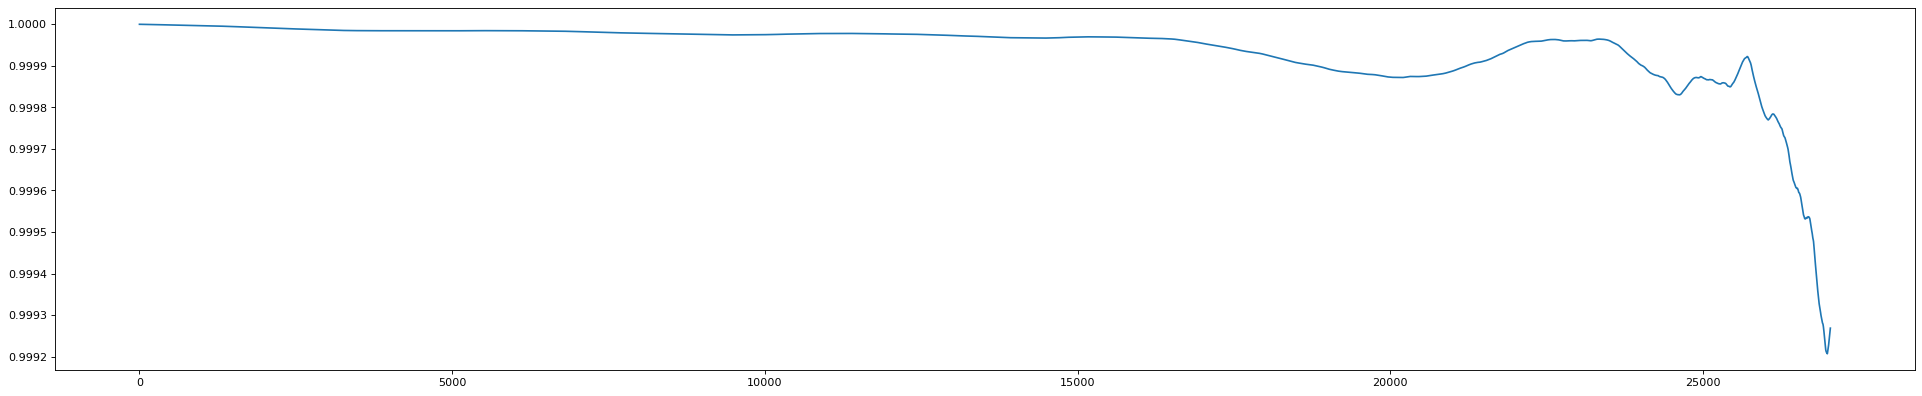

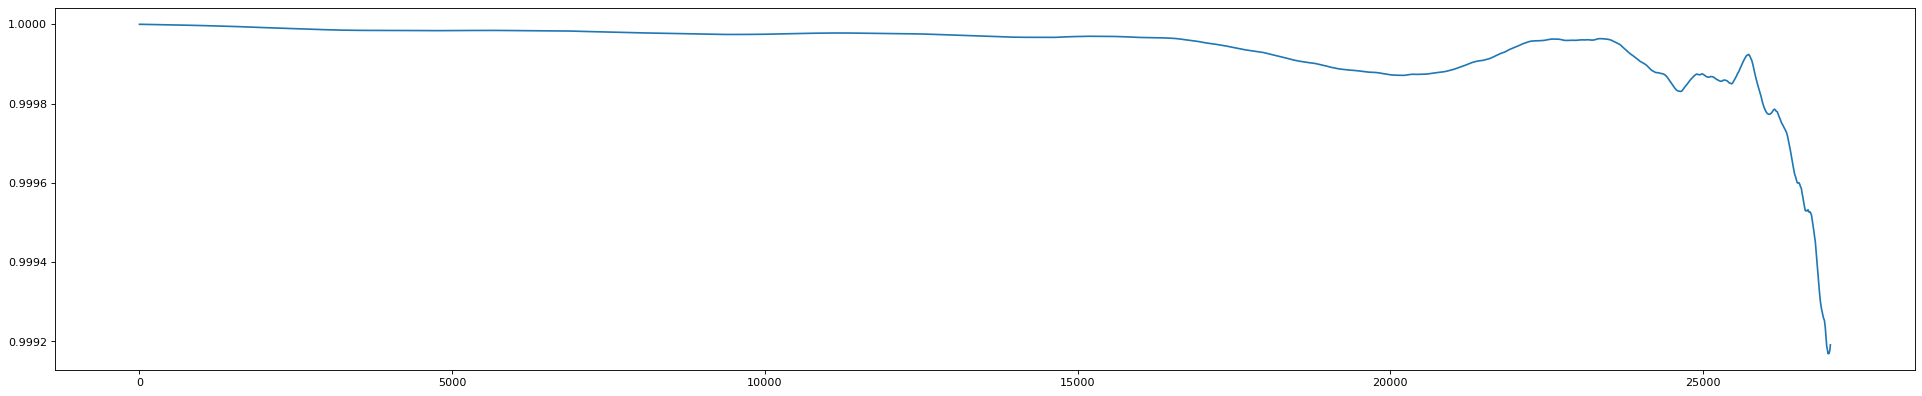

In [221]:
model = find_mapping(sglx_t, tdt_t)

In [222]:
def visualize_mapping(sglx_onset_times, tdt_onset_times, model, nPulsesToPlot=100):
    remapped_tdt_times = model.predict(tdt_t.reshape((-1, 1)))
    
    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.vlines(sglx_onset_times[:nPulsesToPlot], 0, 1, colors='black')
    plt.vlines(remapped_tdt_times[:nPulsesToPlot], 0, 1, linestyle='dotted', colors='red')

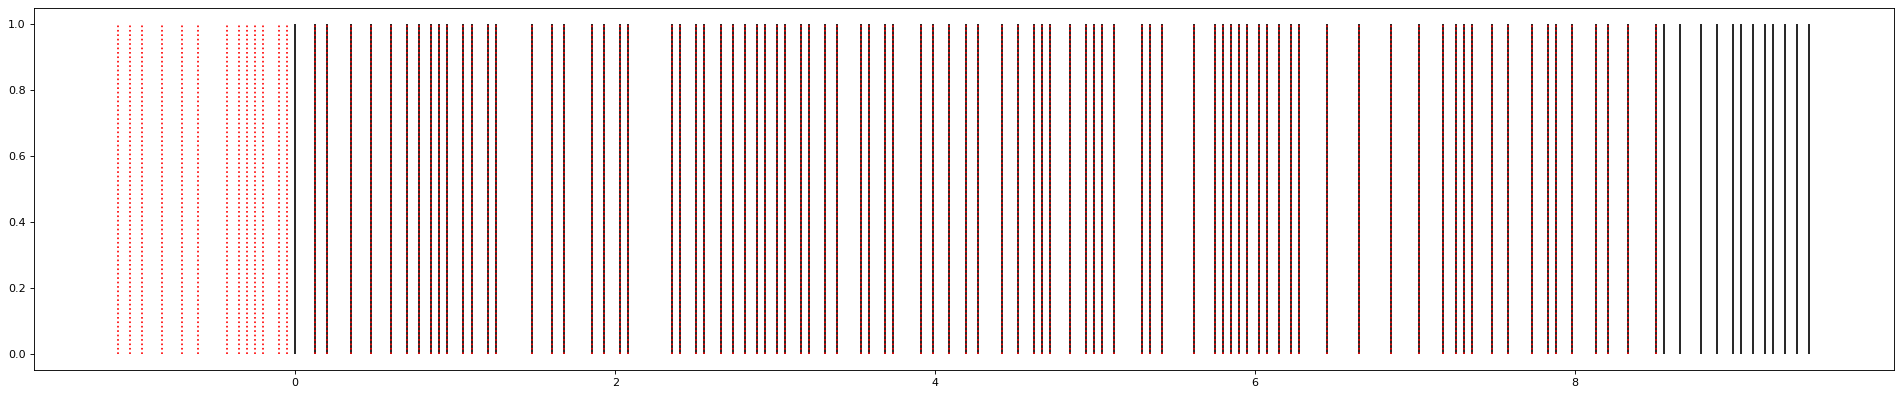

In [223]:
visualize_mapping(sglx_onset_times, tdt_onset_times, model)

# Get TDT stimulation times

In [415]:
def get_stim_times(tdt_data):
    CntA = tdt_data.epocs.CntA
    PeA_ = tdt_data.epocs.PeA_
    
    n_strobes = np.size(PeA_.onset)
    stim_t = np.array([])
    
    for strobe in np.arange(n_strobes):
        strobe_ISI = PeA_.data[strobe] / 1000
        n_strobe_stims = CntA.data[strobe]
        strobe_start = PeA_.onset[strobe]
        strobe_stims = strobe_start + np.arange(n_strobe_stims) * strobe_ISI
        stim_t = np.append(stim_t, strobe_stims)
        
    return stim_t  

In [427]:
def get_stim_samples(tdt_data):
    eS1r = tdt_data.streams.eS1r
    stim_times = get_stim_times(tdt_data)
    return np.rint(stim_times * eS1r.fs).astype('int')

In [400]:
tdt_data = tdt.read_block(tdt_file)

read from t=0s to t=2808.57s


In [429]:
stim_times = get_stim_times(tdt_data)

In [468]:
def visualize_stims(tdt_data, first_stim=0, last_stim=4, before=100, after=100, ch=8):
    stim_samples = get_stim_samples(tdt_data)
    samplesToPlot = np.arange(stim_samples[first_stim] - before, stim_samples[last_stim] + after)

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(samplesToPlot, tdt_data.streams.eS1r.data[ch, samplesToPlot])
    plt.vlines(stim_samples[first_stim : last_stim + 1], 0, 1000, linestyle='dotted', colors='black')

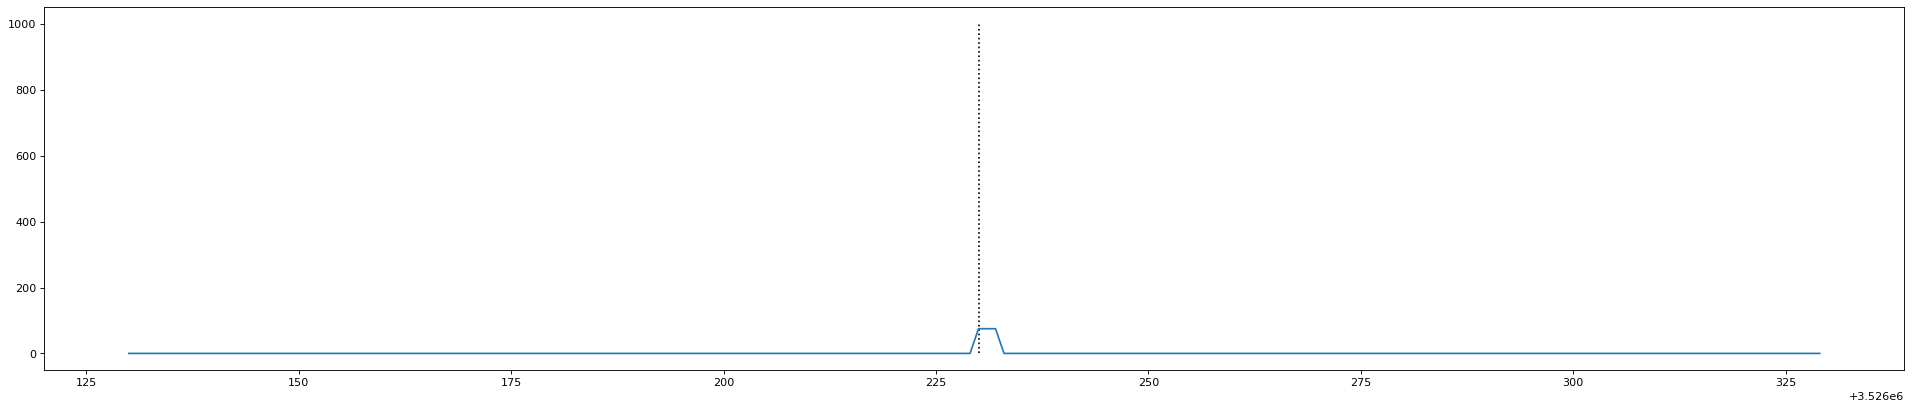

In [486]:
visualize_stims(tdt_data, first_stim=10, last_stim=10)

In [458]:
# imec_times = model.predict(tdt_stim_times)
# should also consider a sliding window strategy

In [493]:
sglx_stim_times = model.predict(stim_times.reshape((-1, 1)))
sglx_stim_times

array([ 375.45680958,  379.45677   ,  383.45673042,  387.45669084,
        391.45665126,  415.62598954,  419.62594997,  423.62591039,
        427.62587081,  431.62583123,  576.55805219,  580.55801262,
        584.55797304,  588.55793346,  592.55789388,  596.5578543 ,
        600.55781473,  604.55777515,  608.55773557,  612.55769599,
        635.43848429,  639.43844471,  643.43840513,  647.43836555,
        651.43832598,  655.4382864 ,  659.43824682,  663.43820724,
        667.43816766,  671.43812809,  780.01800022,  784.01796064,
        788.01792107,  792.01788149,  796.01784191,  800.01780233,
        804.01776275,  808.01772318,  812.0176836 ,  816.01764402,
        890.9325321 ,  894.93249253,  898.93245295,  902.93241337,
        906.93237379,  910.93233421,  914.93229464,  918.93225506,
        922.93221548,  926.9321759 , 1026.33605075, 1030.33601117,
       1034.33597159, 1038.33593202, 1042.33589244, 1046.33585286,
       1050.33581328, 1054.3357737 , 1058.33573412, 1062.33569

In [492]:
savemat('sglx_stim_times.mat', {'sglx_stim_times': sglx_stim_times})